# **Clasificación de actividades y categorías de poses humanas en imágenes**

## Autores

* #### Alejandro Torres Rodríguez
* #### Javier Moreno Morón
* #### Ariel Terrón Rosas
* #### Iván Salinas López

In [1]:
google_drive = False

In [2]:
def get_path(path):
    """
    Si estamos trabajando en colab devuelve el camino correcto y si estamos
    en local devuelve el mismo camino que le pasamos
    """
    if google_drive:
        path = '/content/drive/MyDrive/' + path

    return path

# **0. Librerías**

Se importan las librerías que vamos a necesitar

In [3]:
if google_drive:
    !pip install -Uqq fastbook
    !pip install nbdev
    from google.colab import drive

import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *
from fastdownload import FastDownload
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

if google_drive:
    drive.mount('/content/drive')

fastcore version 1.5.29 installed
fastai version 2.7.13 installed


# **1. Problema a resolver**

## **1.1 Definición**

Nuestro problema trata sobre la estimación automática de la pose en imágenes. Identificar la acción que se desarrolla en una imagen no solo puede proporcionarnos una valiosa comprensión de nuestro entorno, sino también nos permite monitorizar diversas actividades.

## **1.2 Enfoque**

Para resolver nuestro problema utilizaremos dos enfoques:

*   Técnicas de aprendizaje profundo utilizando transferencia de aprendizaje a partir de redes preentrenadas. (VGG16, Resnet18 y GoogleNet)
*   Técnicas de extracción manual de características, en este caso, BoVW (Bag of Visual Words)



# **2. Datos**

El conjunto de datos que vamos a utilizar se denomina *MPI Human Pose Dataset* en inglés. Es un conjunto de datos que se considera como el punto de referencia para la evaluación de la pose humana en imágenes y se encuentra disponible en la siguiente web [http://human-pose.mpi-inf.mpg.de/](http://human-pose.mpi-inf.mpg.de/) de forma abierta para todos los usuarios.

Según la información de la web el conjunto esta formado por alrededor de 25.000 imágenes en las que se encuentran aproximadamente unas 40.000 personas. El conjunto de datos cubre 410 actividades humanas y todas las imágenes tienen una etiqueta de actividad. Todas las imágenes se obtuvieron de vídeos de YouTube.

## **2.1 Carga de datos**

Las imágenes y las etiquetas se encuentran en ficheros distintos. Para descargar los datos usamos el siguiente enlace [http://human-pose.mpi-inf.mpg.de/#download](http://human-pose.mpi-inf.mpg.de/#download).

Como el dataset es muy grande para evitar descargarlo cada vez que ejecutamos todas las celdas del colab utilizamos la variable `download` del siguiente bloque de código que por defecto ponemos a `False` porque nosotros ya hemos descargado todos los datos.

In [4]:
download = False # Controla si se descargan los datos o no

El siguiente bloque de código descarga las imágenes del dataset en el directorio `fastai/downloaded` y las extra en el directorio `fastai/extracted`.

In [5]:
# Descarga de las imágenes
if download:
    # Cambiamos al directorio local de cada uno
    if google_drive:
        %cd '/content/drive/MyDrive'

    data_url = 'https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1.tar.gz'

    # Descargamos los datos y los descomprimimos
    # Los datos comprimidos se guardan en fastai/downloaded
    # Los datos descomprimidos se guardan en fastai/extracted
    downloader = FastDownload(base='fastai', archive='downloaded', data='extracted')
    path = downloader.get(data_url, force=True)

    print(path)

    # Volvemos al directorio original
    if google_drive:
        %cd '/content'

El siguiente bloque de código descarga las etiquetas de cada imágen del dataset en el direcorio `fastai/download` y las extrae en el direcorio `fastai/extracted`.

In [6]:
# Descarga de las anotaciones
if download:
    # Cambiamos al directorio local de cada uno
    if google_drive:
        %cd '/content/drive/MyDrive'

    data_url = 'https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1_u12_2.zip'

    # Descargamos las anotaciones
    downloader = FastDownload(base='fastai', archive='downloaded', data='extracted')
    path = downloader.get(data_url, force=True)

    print(path)

    # Volvemos al directorio original
    if google_drive:
        %cd '/content'

## **2.2 Exploración de los datos**

Una vez descargados los datos, utilizamos el archivo mpii_human_pose_v1_u12_1.mat que contiene la información sobre cada una de las imágenes

In [7]:
# Cargar el archivo .mat
datos_matlab = scipy.io.loadmat(
    get_path('fastai/extracted/mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat'), \
    struct_as_record=False
)

Según la información del sitio web las anotaciones vienen en un fichero matlab con la siguiente estructura:

* `.annolist(imgidx)` - Anotaciones de la imágen identificada por `imgidx`.
  * `.image.name` - Nombre de la imágen.
  * `.annorect(ridx)` - Anotaciones corporales de la persona con índice `ridx`.
    * `.vidx` - Índice del video en `video_list`.
    * `.frame_sec` - Posición de la imágen en el vídeo, en segundos.
    * `.x1, .y1, .x2, .y2` - Coordenadas del rectángulo que contiene a la cabeza de la persona.
    * `.scale` - Escala de la persona con referencia a 200 píxeles de altura.
    * `.objpos` - Posición aproximada de la persona en la imágen.
    * `annopoints.point` - Anotaciones de las articulaciones centradas en la persona.
      * `.x, .y` - Coordenadas de la articulación.
      * `id` - Identificador de articulación (0 - tobillo derecho, 1 - rodilla derecha, 2 - cadera derecha, 3 - cadera izquierda, 4 - rodilla izquierda, 5 - tobillo izquierdo, 6 - pelvis, 7 - tórax, 8 - parte superior del cuello, 9 - parte superior de la cabeza, 10 - muñeca derecha, 11 - codo derecho, 12 - hombro derecho, 13 - hombro izquierdo, 14 - codo izquierdo, 15 - muñeca izquierda)
      * `is_visible` - Visibilidad de la articulación.
  * `img_train(imgidx)`: Asignación de la imágen entrenamiento o test.
  * `single_person(imgidx)` - Contiene los identificadores `ridx` de los rectángulos de personas suficientemente separadas.
  * `act(imgidx)` - Etiqueta de actividad/categoría para la imágen con índice `imgidx`.
    * `act_name` - Nombre de la actividad.
    * `cat_name` - Nombre de la categoría.
    * `act_id` - Identificador de la actividad.
  * `video_list(videoidx)` - Identificador del vídeo proporcionado por YouTube.

In [8]:
# Acceder a la variable RELEASE
release = datos_matlab['RELEASE']

# Imprimir la información sobre la variable RELEASE
print(f"Nombre: RELEASE, Dimensiones: {release.shape}")

struct_release = release[0, 0]

# Explorar más profundamente si es necesario
# Por ejemplo, si primer_elemento es una estructura (mat_struct), puedes acceder a sus campos
#campos = struct_release.__dict__
campos = vars(struct_release) # es lo mismo que la linea de arriba pero es más correcto

# # Imprimir información sobre cada campo
for nombre_campo, valor_campo in campos.items():
      print(f"\nCampo: {nombre_campo}")
      print(f"Tipo de dato: {type(valor_campo)}")
      print(f"Contenido: {valor_campo}")

Nombre: RELEASE, Dimensiones: (1, 1)

Campo: _fieldnames
Tipo de dato: <class 'list'>
Contenido: ['annolist', 'img_train', 'version', 'single_person', 'act', 'video_list']

Campo: annolist
Tipo de dato: <class 'numpy.ndarray'>
Contenido: [[<scipy.io.matlab._mio5_params.mat_struct object at 0x7fb4f247c890> <scipy.io.matlab._mio5_params.mat_struct object at 0x7fb69c180c90>
  <scipy.io.matlab._mio5_params.mat_struct object at 0x7fb4e5c43390> ... <scipy.io.matlab._mio5_params.mat_struct object at 0x7fb4b46d8cd0>
  <scipy.io.matlab._mio5_params.mat_struct object at 0x7fb4b46d9cd0> <scipy.io.matlab._mio5_params.mat_struct object at 0x7fb4b44f9410>]]

Campo: img_train
Tipo de dato: <class 'numpy.ndarray'>
Contenido: [[0 0 0 ... 1 0 0]]

Campo: version
Tipo de dato: <class 'numpy.ndarray'>
Contenido: ['12']

Campo: single_person
Tipo de dato: <class 'numpy.ndarray'>
Contenido: [[array([[1]], dtype=uint8)]
 [array([], shape=(0, 1), dtype=uint8)]
 [array([[1]], dtype=uint8)]
 ...
 [array([[5]], 

Verificamos que en el primer nivel de la estructura encontramos los campos `annolist`, `img_train`, `single_person`, `act` y `video_list`.

In [9]:
act = struct_release.act

# Imprimir información sobre img_train
print(f"Tipo del campo act: {type(act)}")
print(f"Dimensiones del campo act: {act.shape}")

struct_act = act[888,0]

print(vars(struct_act))

# Imprimir los datos
print(f"cat_name: {struct_act.cat_name}")
print(f"act_name: {struct_act.act_name}")
print(f"act_id: {struct_act.act_id}")

Tipo del campo act: <class 'numpy.ndarray'>
Dimensiones del campo act: (24987, 1)
{'_fieldnames': ['cat_name', 'act_name', 'act_id'], 'cat_name': array(['winter activities'], dtype='<U17'), 'act_name': array(['skiing, downhill'], dtype='<U16'), 'act_id': array([[960]], dtype=uint16)}
cat_name: ['winter activities']
act_name: ['skiing, downhill']
act_id: [[960]]


Vemos que los campos que contiene la estructura `act` se corresponden a las etiquetas `act_name`, `cat_name`  y `act_id`. Para mostrarlo hemos utilizado la imágen en el índice `888` como prueba.

A continuación, creamos un dataframe con la librería pandas incluyendo los atributos más relevantes para nuestro problema que son el nombre del archivo, la asignación de entrenamiento/test, la asignación de una o varias personas y las etiquetas.

In [10]:
annot_df = pd.DataFrame()

annolist = campos['annolist']
img_train = campos['img_train']
single_person = campos['single_person']
act = campos['act']

for i in range(annolist.shape[1]):
    image_name = annolist[0, i].image[0, 0].name

    # Comprobación de single_person
    if(single_person[i,0].size > 0):
        num_pers = single_person[i,0][0,0]
    else:
        num_pers = 0

    fila_nueva = {'file name': image_name[0],
                  'img train': img_train[0, i],
                  'single_person': num_pers}

    # Comprobación de act
    datos_dict = act[i,0].__dict__
    act_id = datos_dict['act_id'][0,0]

    if(act_id != -1):
        act_fila = {'cat name': datos_dict['cat_name'][0],
                    'act name': datos_dict['act_name'][0],
                    'act id': act_id}
    else:
        act_fila = {'cat name': 'NaN',
                    'act name': 'NaN',
                    'act id': act_id}

    fila_nueva.update(act_fila)

    annot_df = pd.concat([annot_df, pd.DataFrame([fila_nueva])], ignore_index=True)

In [11]:
annot_df

file name  img train  single_person        cat name     act name  \
0      037454012.jpg          0              1             NaN          NaN   
1      095071431.jpg          0              0             NaN          NaN   
2      073199394.jpg          0              1             NaN          NaN   
3      059865848.jpg          0              1             NaN          NaN   
4      015601864.jpg          1              1          sports      curling   
...              ...        ...            ...             ...          ...   
24982  072772110.jpg          1              1  transportation  pushing car   
24983  039361034.jpg          1              1  transportation  pushing car   
24984  084761779.jpg          1              5  transportation  pushing car   
24985  092025825.jpg          0              0             NaN          NaN   
24986  053686627.jpg          0              0             NaN          NaN   

       act id  
0          -1  
1          -1  
2          -1  
3          -1  
4           1  
...       ...  
24982     972  
24983     972  
24984     972  
24985      -1  
24986      -1  

[24987 rows x 6 columns]

El dataframe consta de:

* `file name`: nombre del archivo de la imagen
* `img train`: 0 si es del conjunto de test, 1 si es del conjunto de train
* `single_person`: número de personas que aparecen en la imagen
* `cat name`: nombre de la categoría
* `act name`: nombre de la actividad (puede estar compuesto de varias actividades en una sola)
* `act id`: identificador de la actividad (un número)



## **2.3 Preprocesado**

Nuestro dataset tiene un problema: el conjunto de test no está etiquetado y entonces no podemos usarlo para medir el rendimiento de nuestro modelo. Para solucionarlo, como tenemos bastantes imágenes, eliminamos las imágenes que pertenecen a test y utilizamos el conjunto de train como dataset completo (posteriormente separaremos en train y test)

In [12]:
# Nos quedamos solo con las imágenes de train que usaremos como dataset completo (test no está etiquetado)
annot_df_filtrado = annot_df.loc[annot_df['img train'] == 1]

# Eliminamos columnas que no nos sirven
columnas_a_eliminar = ["img train", "single_person"]

# Utiliza el método drop para eliminar las columnas
dataset_final = annot_df_filtrado.drop(columnas_a_eliminar, axis=1)

# Resetamos los índices
dataset_final = dataset_final.reset_index(drop=True)

In [13]:
dataset_final

file name        cat name     act name  act id
0      015601864.jpg          sports      curling       1
1      015599452.jpg          sports      curling       1
2      005808361.jpg          sports      curling       1
3      086617615.jpg          sports      curling       1
4      060111501.jpg          sports      curling       1
...              ...             ...          ...     ...
18074  033474347.jpg  transportation  pushing car     972
18075  082650067.jpg  transportation  pushing car     972
18076  072772110.jpg  transportation  pushing car     972
18077  039361034.jpg  transportation  pushing car     972
18078  084761779.jpg  transportation  pushing car     972

[18079 rows x 4 columns]

In [14]:
filas_sin_etiqueta = dataset_final[dataset_final['act name'] == 'NaN']
filas_sin_etiqueta

file name cat name act name  act id
1784   082846930.jpg      NaN      NaN      -1
4017   003994797.jpg      NaN      NaN      -1
4995   096802217.jpg      NaN      NaN      -1
4997   016695018.jpg      NaN      NaN      -1
5241   074972575.jpg      NaN      NaN      -1
6120   054840094.jpg      NaN      NaN      -1
6121   019731397.jpg      NaN      NaN      -1
6122   031725522.jpg      NaN      NaN      -1
6123   028192955.jpg      NaN      NaN      -1
6310   064025091.jpg      NaN      NaN      -1
6312   041813160.jpg      NaN      NaN      -1
7816   077716120.jpg      NaN      NaN      -1
7817   022898719.jpg      NaN      NaN      -1
7830   033908761.jpg      NaN      NaN      -1
7863   035121702.jpg      NaN      NaN      -1
7869   029127252.jpg      NaN      NaN      -1
7871   077639137.jpg      NaN      NaN      -1
7874   075750982.jpg      NaN      NaN      -1
7901   093782721.jpg      NaN      NaN      -1
8049   083112722.jpg      NaN      NaN      -1
11419  043529133.jpg      NaN      NaN      -1
13086  021095272.jpg      NaN      NaN      -1
13087  037022949.jpg      NaN      NaN      -1
13527  016035911.jpg      NaN      NaN      -1
13682  095390600.jpg      NaN      NaN      -1
13685  089861181.jpg      NaN      NaN      -1
13784  024768688.jpg      NaN      NaN      -1
13928  038351509.jpg      NaN      NaN      -1
13929  006877060.jpg      NaN      NaN      -1
13952  098538514.jpg      NaN      NaN      -1
14490  033821652.jpg      NaN      NaN      -1
14825  062307103.jpg      NaN      NaN      -1
14827  034910412.jpg      NaN      NaN      -1
15996  098074273.jpg      NaN      NaN      -1
16000  037447790.jpg      NaN      NaN      -1
16035  041449753.jpg      NaN      NaN      -1
16370  059200298.jpg      NaN      NaN      -1
16391  026606219.jpg      NaN      NaN      -1
16548  012756855.jpg      NaN      NaN      -1
16701  040063704.jpg      NaN      NaN      -1
16941  056157574.jpg      NaN      NaN      -1
17216  030024885.jpg      NaN      NaN      -1
17450  024898327.jpg      NaN      NaN      -1
17451  046464600.jpg      NaN      NaN      -1
17452  096572662.jpg      NaN      NaN      -1
17587  041400068.jpg      NaN      NaN      -1

En el dataset filtrado hay elementos que siguen sin estar etiquetados por lo que removemos estos elementos del dataset.

In [15]:
# Obtenemos los indices de las filas que no tienen etiqueta
indices_a_eliminar = filas_sin_etiqueta.index.values

# Eliminamos las filas sin etiqueta
dataset_final = dataset_final.drop(indices_a_eliminar, axis=0)

In [16]:
dataset_final

file name        cat name     act name  act id
0      015601864.jpg          sports      curling       1
1      015599452.jpg          sports      curling       1
2      005808361.jpg          sports      curling       1
3      086617615.jpg          sports      curling       1
4      060111501.jpg          sports      curling       1
...              ...             ...          ...     ...
18074  033474347.jpg  transportation  pushing car     972
18075  082650067.jpg  transportation  pushing car     972
18076  072772110.jpg  transportation  pushing car     972
18077  039361034.jpg  transportation  pushing car     972
18078  084761779.jpg  transportation  pushing car     972

[18033 rows x 4 columns]

In [17]:
class_counts = dataset_final['act name'].value_counts().reset_index()
clases_poco_representativas = class_counts[class_counts['count'] <= 1]
clases_poco_representativas

act name  \
394  sitting, studying, general, including reading andor writing, light effort   
395                                                    teaching exercise class   
396                                     taking medication, sitting or standing   

     count  
394      1  
395      1  
396      1

Si miramos el número de ejemplos por clase podemos comprobar que algunas clases solo tienen un elemento. Esto es un problema ya que al dividir el conjunto de imágenes en train y test esa única imágen solo va a estar en uno de los dos conjuntos produciendo irregularidades en los resultados. Para solucionarlo eliminamos las clases que solo tienen 1 imágen.

In [18]:
indices_a_eliminar = []

for clase in clases_poco_representativas['act name'].values:
    for index in dataset_final[dataset_final['act name'] == clase].index.values:
        indices_a_eliminar.append(index)

dataset_final = dataset_final.drop(indices_a_eliminar, axis=0)

Las imágenes `040348287.jpg`, `002878268.jpg` y `013401523.jpg` no existen en la carpeta de imágenes aunque están incluidas sus anotaciones por lo que las eliminamos del dataframe.

In [19]:
outlayers = ['040348287.jpg', '002878268.jpg', '013401523.jpg']
indices_a_eliminar = []

for outlayer in outlayers:
    indice = dataset_final[dataset_final['file name'] == outlayer].index.values[0]
    indices_a_eliminar.append(indice)

dataset_final = dataset_final.drop(indices_a_eliminar, axis=0)

Tras filtrar el conjunto de datos hemos obtenido un conjunto reducido formado por `18.033` imágenes todas correctamente etiquetadas.

Una vez tenemos todas las imágenes con sus correspondientes etiquetas, dividimos en conjuntos de train y test. Hemos escogido un 20% para test y un 80% para train ya que nuestro conjunto de datos es bastante amplio. Si el conjunto de datos fuese más reducido hubieramos optado por disminuir el tamaño del conjunto de test e incrementar el tamaño del conjunto de entrenamiento.

In [20]:
# Dividir el DataFrame en conjuntos de entrenamiento y test
df_train, df_test = train_test_split(
    dataset_final,
    test_size=0.2,
    random_state=42,
    stratify=dataset_final['act name'])

/home/alejandro/anaconda3/envs/VC/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/alejandro/anaconda3/envs/VC/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [21]:
df_train

file name               cat name  \
3129   054027889.jpg              bicycling   
685    027230733.jpg      winter activities   
10408  048933083.jpg  conditioning exercise   
11882  014934845.jpg       water activities   
17743  085498601.jpg                 sports   
...              ...                    ...   
3364   031291955.jpg                running   
16098  022461692.jpg             occupation   
17209  039031321.jpg             occupation   
4159   097995545.jpg                dancing   
473    037047210.jpg          miscellaneous   

                                                                                            act name  \
3129                                                                                  bicycling, BMX   
685                                                                                 skiing, downhill   
10408                                                                               circuit training   
11882                                           swimming, lake, ocean, river (Taylor Codes 280, 295)   
17743                                                 badminton, social singles and doubles, general   
...                                                                                              ...   
3364                                                                        jogging, on a mini-tramp   
16098                                                                                       forestry   
17209                                    hairstylist (e.g., plaiting hair, manicure, make-up artist)   
4159   general dancing (e.g., disco, folk, Irish step dancing, line dancing, polka, contra, country)   
473                                                             drawing, writing, painting, standing   

       act id  
3129      454  
685       960  
10408     845  
11882     271  
17743     806  
...       ...  
3364      983  
16098     726  
17209     773  
4159      193  
473       689  

[14421 rows x 4 columns]

Como resultado obtenemos un conjunto de entrenamiento formado por `14.426` imágenes y un conjunto de test formado por `3.607` imágenes.

Para comprobar si las clases están balanceadas creamos un histograma con las frecuencias de cada actividad.

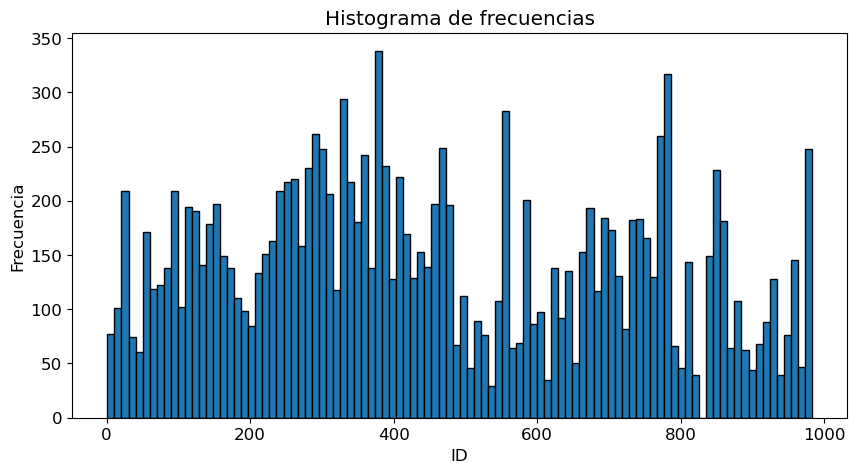

In [22]:
# Crear el histograma directamente desde el DataFrame
df_train['act id'].hist(bins=100, edgecolor='black', grid=False, figsize=(10,5))
plt.title('Histograma de frecuencias')
plt.xlabel('ID')
plt.ylabel('Frecuencia')
plt.show()

Podemos ver que los datos no estan balanceados, por tanto tendremos esto en cuenta a la hora de elegir las medidas de rendimiento del modelo

También vamos a comprobar el número de clases por categoría

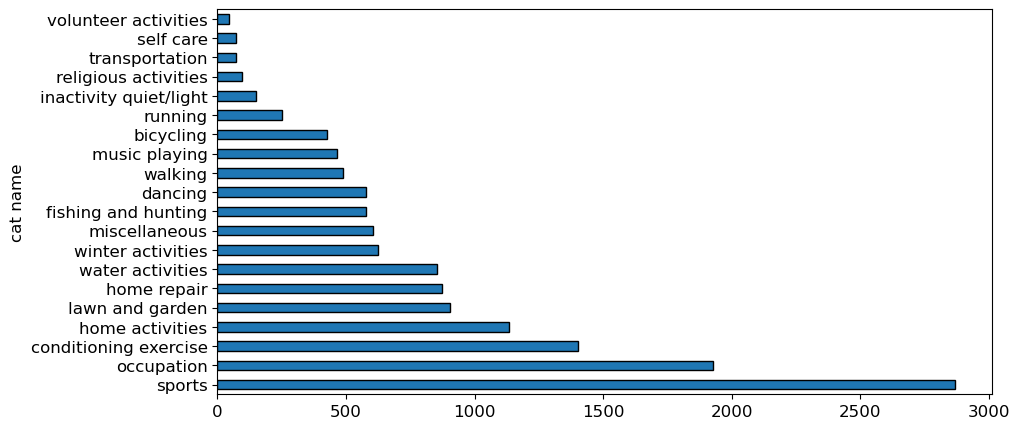

In [23]:
df_train['cat name'].value_counts().plot(kind='barh', edgecolor='black', figsize=(10,5))
plt.show()

Podemos observar como también existe un desbalanceo de datos

In [24]:
SPLITTER = TrainTestSplitter(test_size=0.1, random_state=42, stratify=df_train['act name'])

In [25]:
path = get_path('fastai/extracted/mpii_human_pose_v1/')
batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=SPLITTER,
    get_x=ColReader("file name", pref=path),
    get_y=ColReader("act name"),
    item_tfms=Resize(224),
    batch_tfms = batch_tfms,
).dataloaders(df_train, bs=32)

/home/alejandro/anaconda3/envs/VC/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/alejandro/anaconda3/envs/VC/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


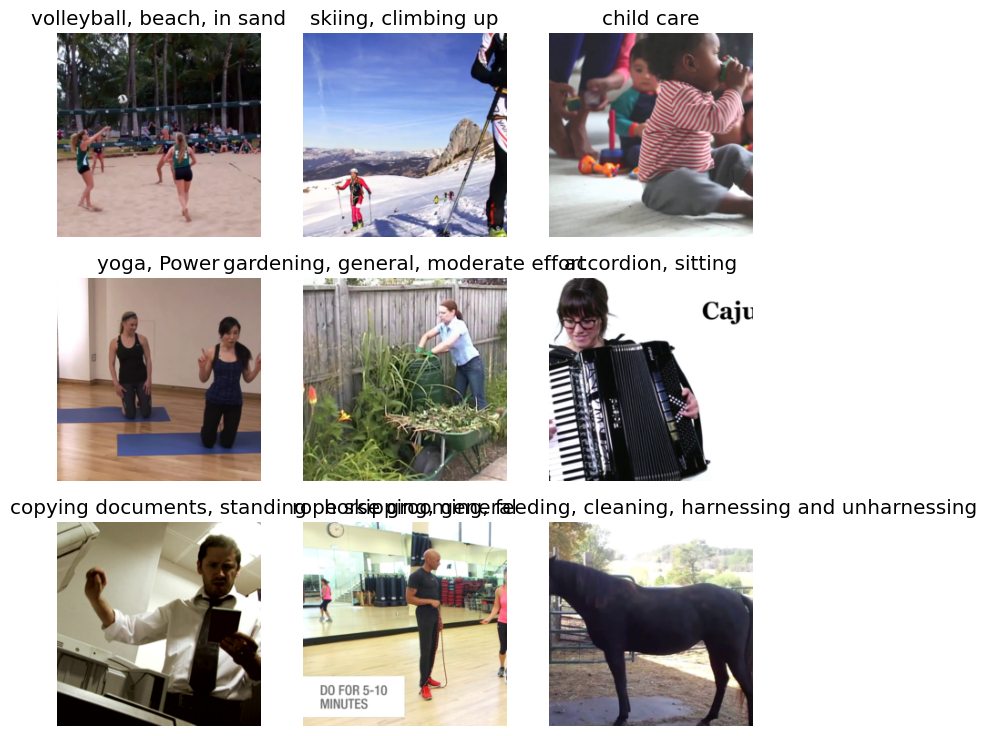

In [26]:
dls.show_batch()

In [27]:
dls_cat = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=SPLITTER,
    get_x=ColReader("file name", pref=path),
    get_y=ColReader("cat name"),
    item_tfms=Resize(224),
    batch_tfms = batch_tfms,
).dataloaders(df_train, bs=32)

/home/alejandro/anaconda3/envs/VC/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/alejandro/anaconda3/envs/VC/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


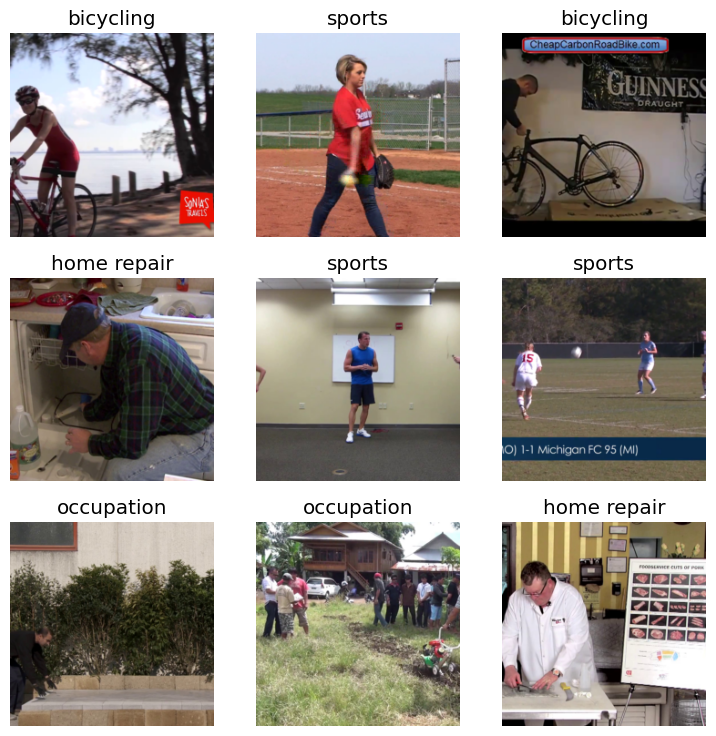

In [28]:
dls_cat.show_batch()

# **3. Modelos**

## **3.1 Clasificación de actividades**

### **3.1.1 Hiperparámetros**

Vamos a decidir algunos de los hiperparámetros a utilizar mediante experimentación basándonos en el siguiente artículo: [Effect of batch size on training dynamics](https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e) que se basa a su vez en estos dos papers: [DON’T DECAY THE LEARNING RATE, INCREASE THE BATCH SIZE](https://arxiv.org/pdf/1711.00489.pdf) y [Train longer, generalize better: closing the generalization gap in large batch training of neural networks](https://arxiv.org/pdf/1705.08741.pdf)

#### **Tamaño de batch**

En los papers mencionados anteriormente se realiza un experimento sobre como influye el tamaño de los batches en el entrenamiento y se concluye que, en general, un tamaño de batch menor produce mejores resultados pero que estos mismos resultados se pueden obtener con un tamaño de batch mayor si se incrementa también el learning rate.

Para realizar nuestro experimento utilizaremos un learning rate fijo de `0.001` y entrenaremos la `VGGNet16` con tamaños de batch de `32`, `64` y `128`.

In [ ]:
path = get_path('fastai/extracted/mpii_human_pose_v1/')
batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=SPLITTER,
    get_x=ColReader("file name", pref=path),
    get_y=ColReader("act name"),
    item_tfms=Resize(224),
    batch_tfms = batch_tfms,
).dataloaders(df_train, bs=32)

learner = vision_learner(
    deepcopy(dls),
    models.vgg16_bn,
    loss_func=CrossEntropyLossFlat(),
    metrics=accuracy,
    train_bn=False)

print(f'Batch size: 32')
learner.fine_tune(epochs=10, base_lr=1e-3, freeze_epochs=1)


Batch size: 32


In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=SPLITTER,
    get_x=ColReader("file name", pref=path),
    get_y=ColReader("act name"),
    item_tfms=Resize(224),
    batch_tfms = batch_tfms,
).dataloaders(df_train, bs=64)

learner = vision_learner(
    deepcopy(dls),
    models.vgg16_bn,
    loss_func=CrossEntropyLossFlat(),
    metrics=accuracy,
    train_bn=False)

print(f'Batch size: 64')
learner.fine_tune(epochs=10, base_lr=1e-3, freeze_epochs=1)

Batch size: 64


In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=SPLITTER,
    get_x=ColReader("file name", pref=path),
    get_y=ColReader("act name"),
    item_tfms=Resize(224),
    batch_tfms = batch_tfms,
).dataloaders(df_train, bs=128)

learner = vision_learner(
    deepcopy(dls),
    models.vgg16_bn,
    loss_func=CrossEntropyLossFlat(),
    metrics=accuracy,
    train_bn=False)

print(f'Batch size: 128')
learner.fine_tune(epochs=10, base_lr=1e-3, freeze_epochs=1)

Batch size: 128


Los resultados han sido los siguientes:
* Batch size 32: 70,60%
* Batch size 64: 69,29%
* Batch size 128: 65,77%

Podemos verificar que, al igual que en el paper, a medida que hemos ido aumentando el learning rate el rendimiento de nuestro modelo ha ido empeorando por lo que para entrenar a nuestro modelos utilizaremos un tamaño de batch de `32`.

In [ ]:
path = get_path('fastai/extracted/mpii_human_pose_v1/')
batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=SPLITTER,
    get_x=ColReader("file name", pref=path),
    get_y=ColReader("act name"),
    item_tfms=Resize(224),
    batch_tfms = batch_tfms,
).dataloaders(df_train, bs=32)

#### **Optimizador**

Optimizador Adam


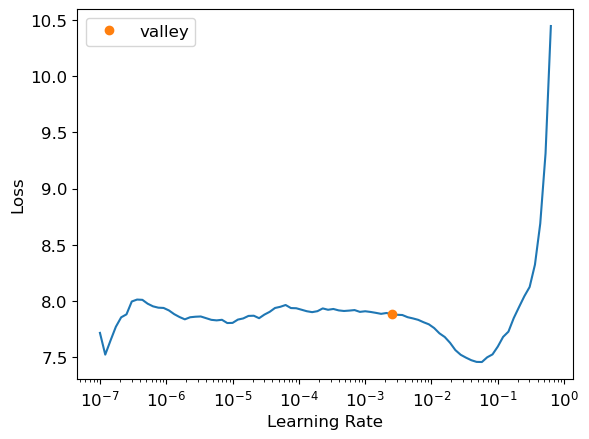

In [ ]:
learner = vision_learner(
    deepcopy(dls),
    models.vgg16_bn,
    loss_func=CrossEntropyLossFlat(),
    metrics=accuracy,
    train_bn=False,
    opt_func=Adam)

print('Optimizador Adam')

lr = learner.lr_find().valley
learner.fine_tune(epochs=10, base_lr=lr, freeze_epochs=1)

Optimizador SGD


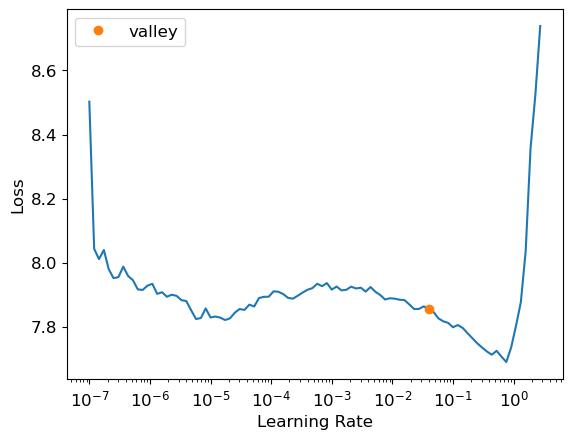

In [ ]:
learner = vision_learner(
    deepcopy(dls),
    models.vgg16_bn,
    loss_func=CrossEntropyLossFlat(),
    metrics=accuracy,
    train_bn=False,
    opt_func=SGD)

print('Optimizador SGD')

lr = learner.lr_find().valley
learner.fine_tune(epochs=10, base_lr=lr, freeze_epochs=1)

En el artículo se concluye que el optimizador `Adam` calcula pesos de mayor tamaño perjudicando a la generalización del modelo frente al `SGD` que calcula pesos de menor tamaño por lo que el optimizador `Adam` suele ir a compañado de weight decay.

En nuestro experimento hemos obtenido los siguientes resultados:
* `Adam`: 74%
* `SGD`: 61,34%

A la vista de nuestros resultados vamos a utilizar `Adam`. La diferencia de resultados respecto al artículo se debe a que, en nuestro caso, el aumento del tamaño de los pesos al utilizar `Adam` no es lo suficientemente significativo como para empeorar el rendimiento del modelo.

#### **Pesos de las clases**

Como hemos visto, existe un gran desbalance de clases, por lo que en la función de pérdida aplicaremos pesos inversamente proporcional al tamaño de cada clase para que se mayor importancia a aquellos ejemplos de clases minoritarias y menos importancia a las clases mayoritarias.

In [30]:
def calcular_pesos_desbalance(dls, df_train):
    """
    Devuelve los pesos inversamente proporcional al número de elementos de
    las clases
    """
    # Calculamos los pesos de clases
    class_counts = df_train['act name'].value_counts().reset_index()
    weights = []

    for i in range(len(dls.vocab)):
        # Obtenemos el nombre de la clase
        clase = dls.vocab[i]

        # Obtenemos el número de imágenes de la clase
        num_imagenes_clase = class_counts[class_counts['act name'] == clase]['count'].values[0]

        # Calculamos el peso
        peso = 1 / num_imagenes_clase

        # Añadimos el peso a la lista
        weights.append(peso)

    weights = np.array(weights)

    # Normalizamos para que la suma de 1
    weights = weights / np.sum(weights)

    class_weights = torch.Tensor(weights)

    return class_weights

In [77]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=SPLITTER,
    get_x=ColReader("file name", pref=path),
    get_y=ColReader("act name"),
    item_tfms=Resize(224),
    batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)],
).dataloaders(df_train, bs=32)

learner_weighted = vision_learner(
    deepcopy(dls),
    models.vgg16_bn,
    loss_func=CrossEntropyLossFlat(weight=calcular_pesos_desbalance(deepcopy(dls), df_train)),
    metrics=[accuracy, F1Score(average='weighted')],
    train_bn=False,
    opt_func=Adam)

learner = vision_learner(
    deepcopy(dls),
    models.vgg16_bn,
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy, F1Score(average='weighted')],
    train_bn=False,
    opt_func=Adam)

/home/alejandro/anaconda3/envs/VC/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/alejandro/anaconda3/envs/VC/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [78]:
learner_weighted.fine_tune(epochs=10, base_lr=1e-3, freeze_epochs=1)

In [79]:
learner.fine_tune(epochs=10, base_lr=1e-3, freeze_epochs=1)

El modelo que no utiliza pesos en las clases ha obtenido un error en validación menor, y un porcentaje de acierto y puntuación F1 mayor. Sabiendo que la puntuación F1 tiene en cuenta el balanceo de clases el ganador es el modelo sin pesos por clases por lo que no utilizaremos pesos de clases en los modelos que entrenaremos más adelante.

#### **Aumento de datos**

Como hay un gran desbalance entre clases vamos a probar a usar aumento de datos para ver si mejora el rendimiento del modelo.

In [ ]:
path = get_path('fastai/extracted/mpii_human_pose_v1/')

# Data loader con aumento de datos
dls_aug = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=SPLITTER,
    get_x=ColReader("file name", pref=path),
    get_y=ColReader("act name"),
    item_tfms=Resize(224),
    batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats), *aug_transforms()],
).dataloaders(df_train, bs=32)

# Data loader sin aumento de datos
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=SPLITTER,
    get_x=ColReader("file name", pref=path),
    get_y=ColReader("act name"),
    item_tfms=Resize(224),
    batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)],
).dataloaders(df_train, bs=32)

# Learner con aumento de datos
learner_aug = vision_learner(
    deepcopy(dls_aug),
    models.vgg16_bn,
    loss_func=CrossEntropyLossFlat(),
    metrics=accuracy,
    train_bn=False,
    opt_func=Adam)

# Learner sin aumento de datos
learner = vision_learner(
    deepcopy(dls),
    models.vgg16_bn,
    loss_func=CrossEntropyLossFlat(),
    metrics=accuracy,
    train_bn=False,
    opt_func=Adam)

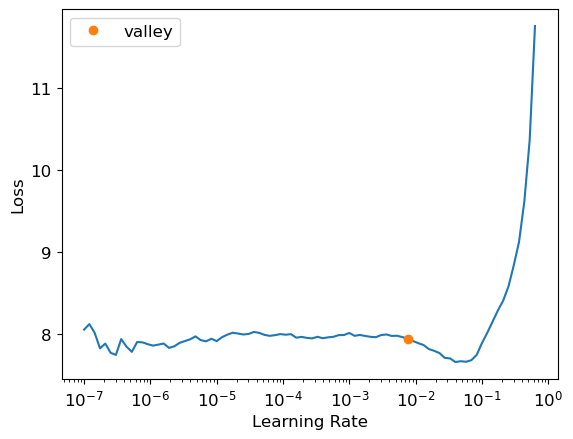

In [ ]:
lr = learner.lr_find().valley

In [ ]:
learner.fine_tune(epochs=10, base_lr=lr, freeze_epochs=1)

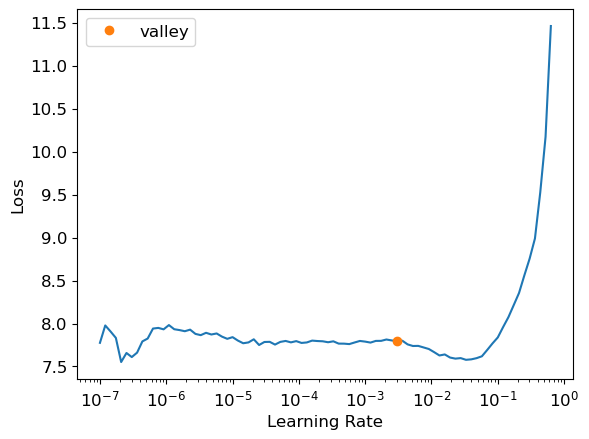

In [ ]:
lr_aug = learner_aug.lr_find().valley

In [ ]:
learner_aug.fine_tune(epochs=10, base_lr=lr_aug, freeze_epochs=1)

Aunque los resultados son similares podemos ver que el learner que utiliza aumento de datos obtiene mejor `accuracy` así como un `train_loss` mayor y un `valid_loss` menor lo que quiere decir que está menos sobreajustado que el modelo sin aumento de datos por lo que utilizaremos esta técnica para entrenar nuestros modelos más adelante.

#### **Learning rate**

Para decidir que learning rate vamos a utilizar aplicamos el buscador de learning rate a cada uno de los modelos y fijandonos en el resultado de cada uno de los modelos elegiremos un learning rate que se adecue más o menos bien a todos ellos.

In [131]:
path = get_path('fastai/extracted/mpii_human_pose_v1/')

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=SPLITTER,
    get_x=ColReader("file name", pref=path),
    get_y=ColReader("act name"),
    item_tfms=Resize(224),
    batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats), *aug_transforms()],
).dataloaders(df_train, bs=32)


loss_function = CrossEntropyLossFlat()
metrics = [accuracy, F1Score(average = 'weighted')]
callbacks = [SaveModelCallback(), EarlyStoppingCallback(patience = 2)]

/home/alejandro/anaconda3/envs/VC/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/alejandro/anaconda3/envs/VC/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [137]:
learner_vgg = vision_learner(
    deepcopy(dls),
    models.vgg16_bn,
    loss_func=deepcopy(loss_function),
    metrics=deepcopy(metrics),
    train_bn=False,
    cbs=deepcopy(callbacks))

learner_resnet18 = vision_learner(
    deepcopy(dls),
    models.resnet18,
    loss_func=deepcopy(loss_function),
    metrics=deepcopy(metrics),
    train_bn=False,
    cbs=deepcopy(callbacks))

learner_googlenet = vision_learner(
    deepcopy(dls),
    models.googlenet,
    loss_func=deepcopy(loss_function),
    metrics=deepcopy(metrics),
    train_bn=False,
    cbs=deepcopy(callbacks))

/home/alejandro/anaconda3/envs/VC/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alejandro/anaconda3/envs/VC/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0014454397605732083)

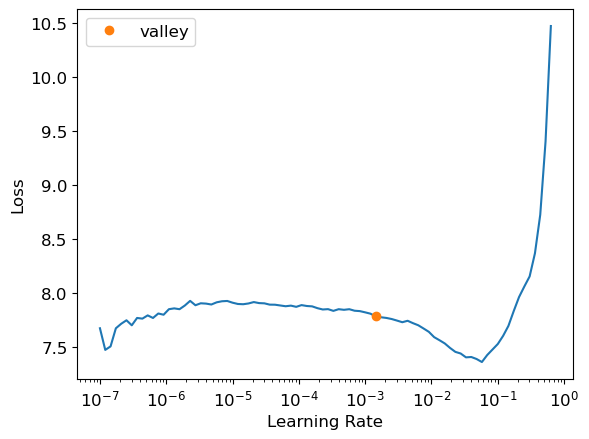

In [138]:
learner_vgg.lr_find()

SuggestedLRs(valley=0.00363078061491251)

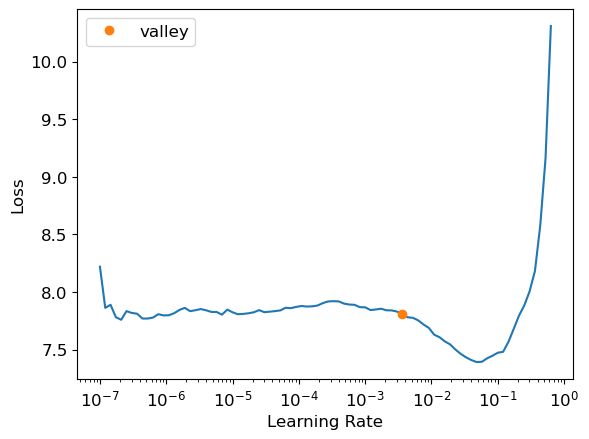

In [139]:
learner_resnet18.lr_find()

SuggestedLRs(valley=0.0030199517495930195)

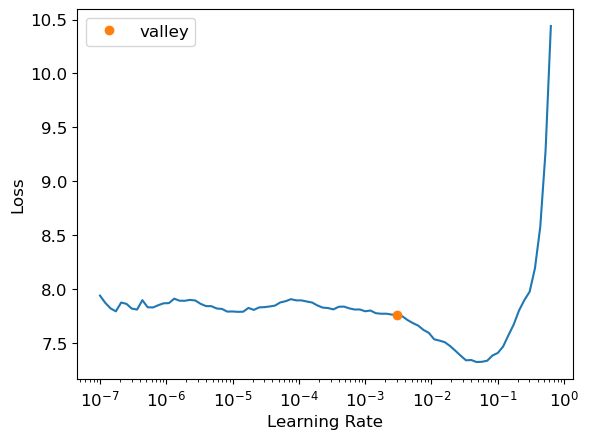

In [140]:
learner_googlenet.lr_find()

Los learning rates sugeridos varían mas o menos entre 0.001 y 0.003 por lo que utilizaremos como learning rate un valor de 0.002

### **3.1.2 Creación**

#### **Métricas**

Vamos a utilizar las siguientes métricas:

* Porcentaje de acierto: mide el porcentaje total de ejemplos bien clasificados por el modelo.
* Puntuación F1: Métrica que tiene en cuenta el desbalance de clases en el conjunto de datos. Los valores oscilan entre 0 y 1.

#### **Redes neuronales convolucionales**

Declaramos primero el data loader y algunos de los parámetros que son comunes a todos los modelos

In [142]:
path = get_path('fastai/extracted/mpii_human_pose_v1/')

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=SPLITTER,
    get_x=ColReader("file name", pref=path),
    get_y=ColReader("act name"),
    item_tfms=Resize(224),
    batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats), *aug_transforms()],
).dataloaders(df_train, bs=32)

loss_function = CrossEntropyLossFlat()
metrics = [accuracy, F1Score(average = 'weighted')]
callbacks = [SaveModelCallback(), EarlyStoppingCallback(patience = 2)]

/home/alejandro/anaconda3/envs/VC/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/alejandro/anaconda3/envs/VC/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Creamos el modelo de la red VGG y mostramos el resumen

In [143]:
learner_vgg = vision_learner(
    deepcopy(dls),
    models.vgg16_bn,
    loss_func=deepcopy(loss_function),
    metrics=deepcopy(metrics),
    train_bn=False,
    cbs=deepcopy(callbacks))

learner_vgg.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 224 x 224 
Conv2d                                    1792       False     
BatchNorm2d                               128        False     
ReLU                                                           
Conv2d                                    36928      False     
BatchNorm2d                               128        False     
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 112 x 112 
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 128 x 112 x 11 
Conv2d                                    73856      False     
BatchNorm2d                               256        False     
ReLU                               

Creamos el modelo con la ResNet18 y mostramos el resumen de la red

In [144]:
# Modelo usando la resnet18
learner_resnet18 = vision_learner(
    deepcopy(dls),
    models.resnet18,
    loss_func=deepcopy(loss_function),
    metrics=deepcopy(metrics),
    train_bn=False,
    cbs=deepcopy(callbacks))

learner_resnet18.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        False     
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
ReLU                      

Creamos el modelo con la GoogleNet y mostramos el resumen

In [158]:
# Modelo usando la google net
learner_googlenet = vision_learner(
    deepcopy(dls),
    models.googlenet,
    loss_func=deepcopy(loss_function),
    metrics=deepcopy(metrics),
    train_bn=False,
    cbs=deepcopy(callbacks))

learner_googlenet.summary()

/home/alejandro/anaconda3/envs/VC/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alejandro/anaconda3/envs/VC/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        False     
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        False     
____________________________________________________________________________
                     32 x 192 x 56 x 56  
Conv2d                                    110592     False     
BatchNorm2d                               384        False     
____________________________________________________________________________
                     32 x 192 x 28 x 28  
MaxPool2d                                   

### **3.1.3 Entrenamiento**

Declaramos el número de épocas tanto congeladas como sin congelar así como el learning rate que son comunes a todos los modelos que vamos a entrenar.

In [146]:
EPOCHS = 20
FREEZE_EPOCHS = 1
LEARNING_RATE = 2e-3

#### **VGG16**

Realizamos el fine tuning de la VGG

In [147]:
# Fine tune usando la cabeza por defecto
learner_vgg.fine_tune(epochs=EPOCHS, base_lr=LEARNING_RATE, freeze_epochs=FREEZE_EPOCHS)

Better model found at epoch 0 with valid_loss value: 2.90738582611084.


Better model found at epoch 0 with valid_loss value: 2.3233790397644043.
Better model found at epoch 1 with valid_loss value: 1.97650146484375.
Better model found at epoch 2 with valid_loss value: 1.7298661470413208.
Better model found at epoch 3 with valid_loss value: 1.5514025688171387.
Better model found at epoch 4 with valid_loss value: 1.4569326639175415.
Better model found at epoch 5 with valid_loss value: 1.3514916896820068.
Better model found at epoch 6 with valid_loss value: 1.3039332628250122.
Better model found at epoch 7 with valid_loss value: 1.1945874691009521.
Better model found at epoch 9 with valid_loss value: 1.1780861616134644.
Better model found at epoch 10 with valid_loss value: 1.1330523490905762.
Better model found at epoch 11 with valid_loss value: 1.1000463962554932.
Better model found at epoch 12 with valid_loss value: 1.0498603582382202.
Better model found at epoch 13 with valid_loss value: 1.0222854614257812.
Better model found at epoch 14 with valid_loss va

#### **Resnet18**


Realizamos el fine tuning de la ResNet18

In [148]:
learner_resnet18.fine_tune(epochs=EPOCHS, base_lr=LEARNING_RATE, freeze_epochs=FREEZE_EPOCHS)

Better model found at epoch 0 with valid_loss value: 2.9873604774475098.


Better model found at epoch 0 with valid_loss value: 2.426276922225952.
Better model found at epoch 1 with valid_loss value: 2.077317714691162.
Better model found at epoch 2 with valid_loss value: 1.8227170705795288.
Better model found at epoch 3 with valid_loss value: 1.619776725769043.
Better model found at epoch 4 with valid_loss value: 1.5258845090866089.
Better model found at epoch 5 with valid_loss value: 1.4369652271270752.
Better model found at epoch 6 with valid_loss value: 1.3709520101547241.
Better model found at epoch 7 with valid_loss value: 1.2995514869689941.
Better model found at epoch 9 with valid_loss value: 1.2994804382324219.
Better model found at epoch 10 with valid_loss value: 1.2323774099349976.
Better model found at epoch 11 with valid_loss value: 1.2182292938232422.
Better model found at epoch 12 with valid_loss value: 1.185611605644226.
Better model found at epoch 13 with valid_loss value: 1.150441288948059.
Better model found at epoch 14 with valid_loss value

#### **GoogLeNet**

Realizamos el fine tuning de la GoogleNet

In [159]:
learner_googlenet.fine_tune(epochs=EPOCHS, base_lr=LEARNING_RATE, freeze_epochs=FREEZE_EPOCHS)

Better model found at epoch 0 with valid_loss value: 2.8982930183410645.


Better model found at epoch 0 with valid_loss value: 2.4793148040771484.
Better model found at epoch 1 with valid_loss value: 2.1687958240509033.
Better model found at epoch 2 with valid_loss value: 1.9717572927474976.
Better model found at epoch 3 with valid_loss value: 1.8349424600601196.
Better model found at epoch 4 with valid_loss value: 1.7219479084014893.
Better model found at epoch 5 with valid_loss value: 1.612772822380066.
Better model found at epoch 6 with valid_loss value: 1.5295995473861694.
Better model found at epoch 7 with valid_loss value: 1.4813778400421143.
Better model found at epoch 8 with valid_loss value: 1.459692120552063.
Better model found at epoch 9 with valid_loss value: 1.4214693307876587.
Better model found at epoch 10 with valid_loss value: 1.3604556322097778.
Better model found at epoch 11 with valid_loss value: 1.323261022567749.
Better model found at epoch 12 with valid_loss value: 1.2867387533187866.
Better model found at epoch 13 with valid_loss valu

### **3.1.4 Bag of Words**

Enlace de interes: https://medium.com/@aybukeyalcinerr/bag-of-visual-words-bovw-db9500331b2f

In [31]:
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans

In [32]:
def load_images_from_folder(abs_path, df):
    images = defaultdict(list)
    i=0
    for _, fila in df.iterrows():
        i = i + 1
        if(i%1000==0):
            print(i)
        path = abs_path + fila["file name"]
        if os.path.exists(path):
            img = cv2.imread(path, 0)
            etiqueta = fila["act name"]

            images[etiqueta].append(img)

    return images

path = get_path('fastai/extracted/mpii_human_pose_v1/')

images = load_images_from_folder(path, df_train)  # take all images category by category
test = load_images_from_folder(path, df_test)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
1000
2000
3000


In [33]:
# Creates descriptors using sift
# Takes one parameter that is images dictionary
# Return an array whose first index holds the decriptor_list without an order
# And the second index holds the sift_vectors dictionary which holds the descriptors but this is seperated class by class
def sift_features(images):
    i = 0
    sift_vectors = {}
    descriptor_list = []
    orb = cv2.ORB_create()
    #sift = cv2.SIFT_create()
    for key,value in images.items():
        features = []
        for img in value:
            i = i+1
            if(i%500==0):
                print(i)
            kp, des = orb.detectAndCompute(img, None)
            # kp, des = sift.detectAndCompute(img,None)
            # Verifica si des es None antes de extender descriptor_list
            if des is not None:
                descriptor_list.extend(des)
                features.append(des)
        sift_vectors[key] = features
    return [descriptor_list, sift_vectors]

sifts = sift_features(images)
# Takes the descriptor list which is unordered one
descriptor_list = sifts[0]
# Takes the sift features that is seperated class by class for train data
all_bovw_feature = sifts[1]
# Takes the sift features that is seperated class by class for test data
test_bovw_feature = sift_features(test)[1]

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
500
1000
1500
2000
2500
3000
3500


In [34]:
# A k-means clustering algorithm who takes 2 parameter which is number
# of cluster(k) and the other is descriptors list(unordered 1d array)
# Returns an array that holds central points.
def kmeans(k, descriptor_list):
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_
    return visual_words

# Takes the central points which is visual words
visual_words = kmeans(150, descriptor_list)

In [35]:
def find_index(feature, centers):
    # Encuentra el índice del centro más cercano para una característica dada
    distances = np.linalg.norm(centers - feature, axis=1)
    return np.argmin(distances)

# Takes 2 parameters. The first one is a dictionary that holds the descriptors that are separated class by class
# And the second parameter is an array that holds the central points (visual words) of the k means clustering
# Returns a dictionary that holds the histograms for each images that are separated class by class.
def image_class(all_bovw, centers):
    dict_feature = {}
    for key,value in all_bovw.items():
        category = []
        for img in value:
            histogram = np.zeros(len(centers))
            for each_feature in img:
                ind = find_index(each_feature, centers)
                histogram[ind] += 1
            category.append(histogram)
        dict_feature[key] = category
    return dict_feature

# Creates histograms for train data
bovw_train = image_class(all_bovw_feature, visual_words)
# Creates histograms for test data
bovw_test = image_class(test_bovw_feature, visual_words)

In [36]:
# 1-NN algorithm. We use this for predict the class of test images.
# Takes 2 parameters. images is the feature vectors of train images and tests is the feature vectors of test images
# Returns an array that holds number of test images, number of correctly predicted images and records of class based images respectively
def knn(images, tests):
    num_test = 0
    correct_predict = 0
    class_based = {}

    for test_key, test_val in tests.items():
        class_based[test_key] = [0, 0] # [correct, all]
        for tst in test_val:
            predict_start = 0
            #print(test_key)
            minimum = 0
            key = "a" #predicted
            for train_key, train_val in images.items():
                for train in train_val:
                    if(predict_start == 0):
                        minimum = distance.euclidean(tst, train)
                        #minimum = L1_dist(tst,train)
                        key = train_key
                        predict_start += 1
                    else:
                        dist = distance.euclidean(tst, train)
                        #dist = L1_dist(tst,train)
                        if(dist < minimum):
                            minimum = dist
                            key = train_key

            if(test_key == key):
                correct_predict += 1
                class_based[test_key][0] += 1
            num_test += 1
            class_based[test_key][1] += 1
            #print(minimum)
    return [num_test, correct_predict, class_based]

# Call the knn function
results_bowl = knn(bovw_train, bovw_test)

In [37]:
# Calculates the average accuracy and class based accuracies.
def accuracy(results):
    avg_accuracy = (results[1] / results[0]) * 100
    print("Average accuracy: %" + str(avg_accuracy))
    print("\nClass based accuracies: \n")
    for key,value in results[2].items():
        acc = (value[0] / value[1]) * 100
        print(key + " : %" + str(acc))

# Calculates the accuracies and write the results to the console.
accuracy(results_bowl)

Average accuracy: %28.43273231622746

Class based accuracies: 

fire fighter : %0.0
horse grooming, feeding, cleaning, harnessing and unharnessing : %20.0
postal carrier, walking to deliver mail : %0.0
laying or removing carpet : %11.11111111111111
skateboarding : %2.7027027027027026
wiring, tapping-splicing : %71.42857142857143
tanning hides, general : %33.33333333333333
frisbee : %0.0
sitting, arts and crafts,  carving wood, weaving, spinning wool : %27.27272727272727
standing, doing work : %15.384615384615385
bowling : %90.0
hunting, birds : %0.0
horseback riding : %11.11111111111111
gardening, general, moderate effort : %18.181818181818183
carpentry, general : %15.625
cooking or food preparation : %52.38095238095239
chopping wood : %52.94117647058824
orange grove work, picking fruit : %40.0
skating, ice : %9.090909090909092
swimming, backstroke : %66.66666666666666
rope skipping, general : %67.74193548387096
reclining : %72.72727272727273
working in scene shop, theater actor, backs

## **3.2 Clasificación de categorías**

### **3.2.1 Creación**

Creamos un nuevo data loader que utiliza como etiquetas las categorías generales en lugar de las actividades.

In [ ]:
path = get_path('fastai/extracted/mpii_human_pose_v1/')
batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats), *aug_transforms()]

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=SPLITTER,
    get_x=ColReader("file name", pref=path),
    get_y=ColReader("cat name"), # Usamos la categoría en lugar de la actividad
    item_tfms=Resize(224),
    batch_tfms = batch_tfms,
).dataloaders(df_train, bs=32)

Mostramos las imágenes para comprobar que se han cargado correctamente

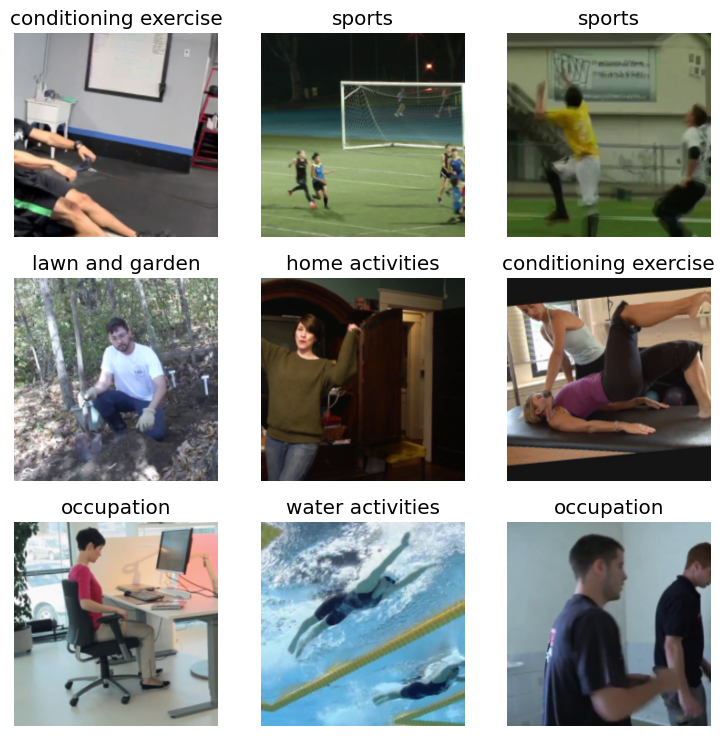

In [ ]:
dls.show_batch()

Declaramos el modelo utilizando la VGG16 ya que ha sido la red que ha obtenido mejor rendimiento en la clasificación de actividades con nuestro dataset

In [ ]:
callbacks = [SaveModelCallback(), EarlyStoppingCallback(patience=2)]

learner_vgg16 = vision_learner(
    deepcopy(dls), 
    models.vgg16_bn, 
    loss_func=CrossEntropyLossFlat(), 
    metrics=[accuracy, F1Score(average = 'weighted')], 
    train_bn=False, 
    cbs=callbacks)

### **3.2.2 Entrenamiento**

Buscamos el learnig rate óptimo ya que este problema es diferente al de la clasificación de las actividades

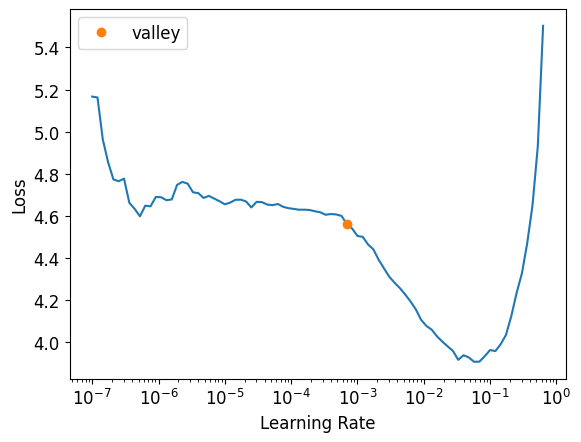

In [ ]:
lr = learner_vgg16.lr_find().valley

Realizamos el fine tune del modelo utilizando el mismo número de épocas congeladas y descongeladas que con las redes anteriores.

In [ ]:
# Fine tune usando la cabeza por defecto
learner_vgg16.fine_tune(epochs=EPOCHS, base_lr=lr, freeze_epochs=FREEZE_EPOCHS)

Better model found at epoch 0 with valid_loss value: 1.4716501235961914.


Better model found at epoch 0 with valid_loss value: 1.2929335832595825.
Better model found at epoch 1 with valid_loss value: 1.1583991050720215.
Better model found at epoch 2 with valid_loss value: 1.0339607000350952.
Better model found at epoch 3 with valid_loss value: 0.9203878045082092.
Better model found at epoch 4 with valid_loss value: 0.8672938942909241.
Better model found at epoch 5 with valid_loss value: 0.8048698902130127.
Better model found at epoch 6 with valid_loss value: 0.7505792379379272.
Better model found at epoch 7 with valid_loss value: 0.727794349193573.
Better model found at epoch 8 with valid_loss value: 0.7163916826248169.
Better model found at epoch 9 with valid_loss value: 0.6850415468215942.
Better model found at epoch 10 with valid_loss value: 0.671829342842102.
No improvement since epoch 10: early stopping


# **4. Resultados**

In [150]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

## **4.1 Clasificación de actividades**

### **VGG**

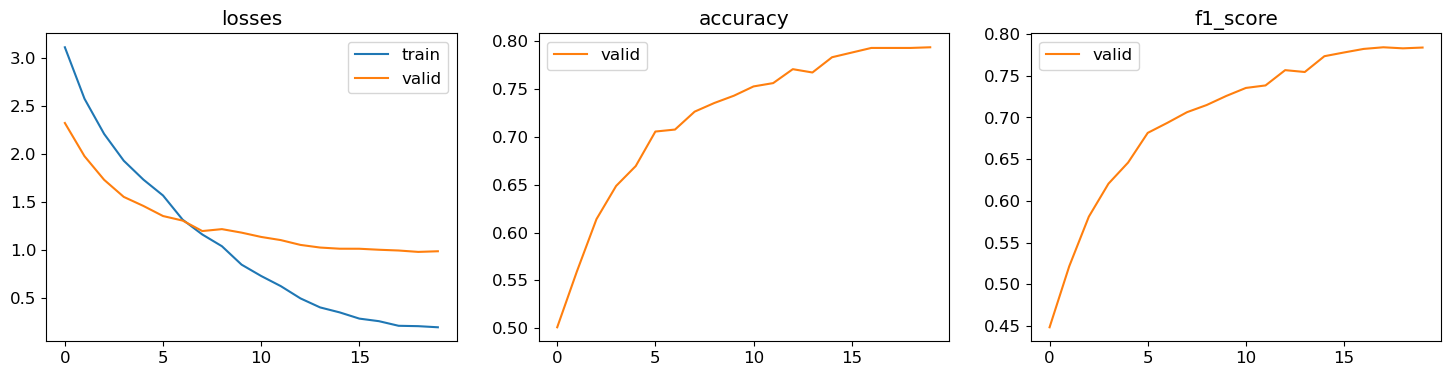

In [151]:
learner_vgg.recorder.plot_metrics()

En las gráficas vemos la evolución de la entrenamiento del modelo VGG. A partir de la época 10 más o menos el error en validación empieza a disminuir a una velocidad menor hasta que se estanca y el entrenamiento se detiene para no sobreajustar el modelo.

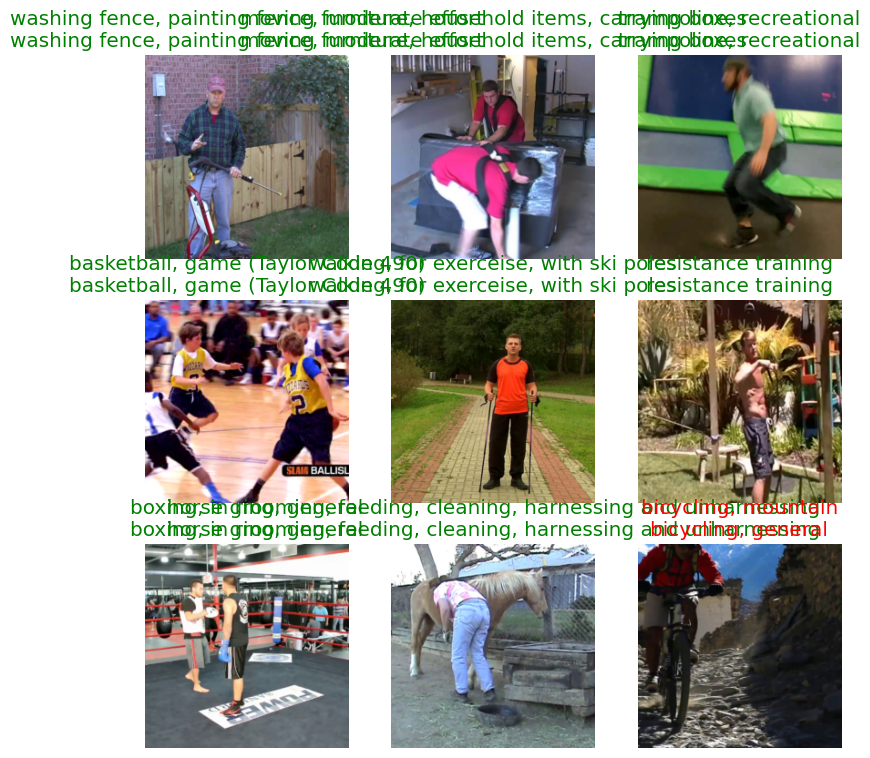

In [152]:
learner_vgg.show_results()

Comprobamos visualmente que el modelo funciona correctamente prediciendo correctamente más de un 90% de las imágenes en este caso.

### **ResNet**

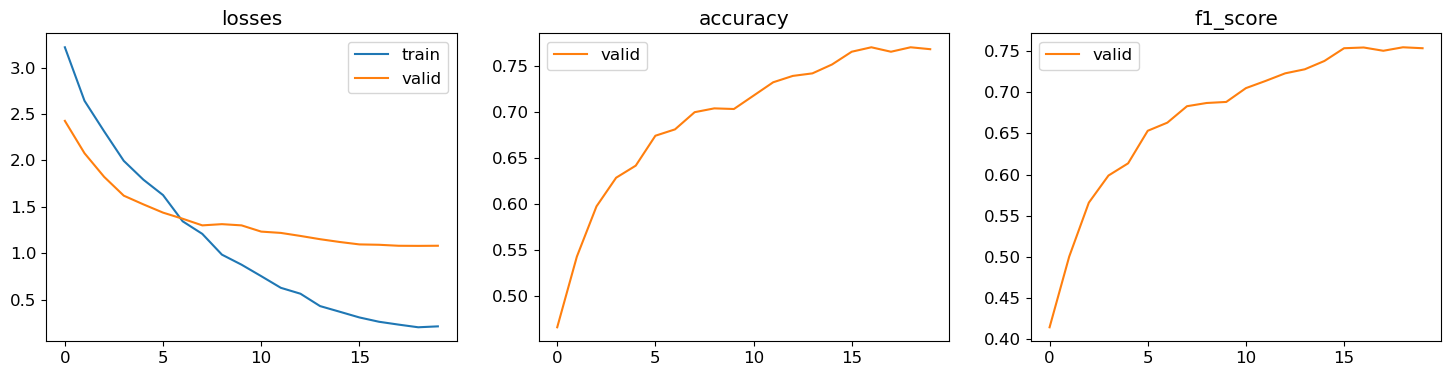

In [153]:
learner_resnet18.recorder.plot_metrics()

En las gráficas de la ResNet18 observamos un comportamiento similar a las de la VGG.

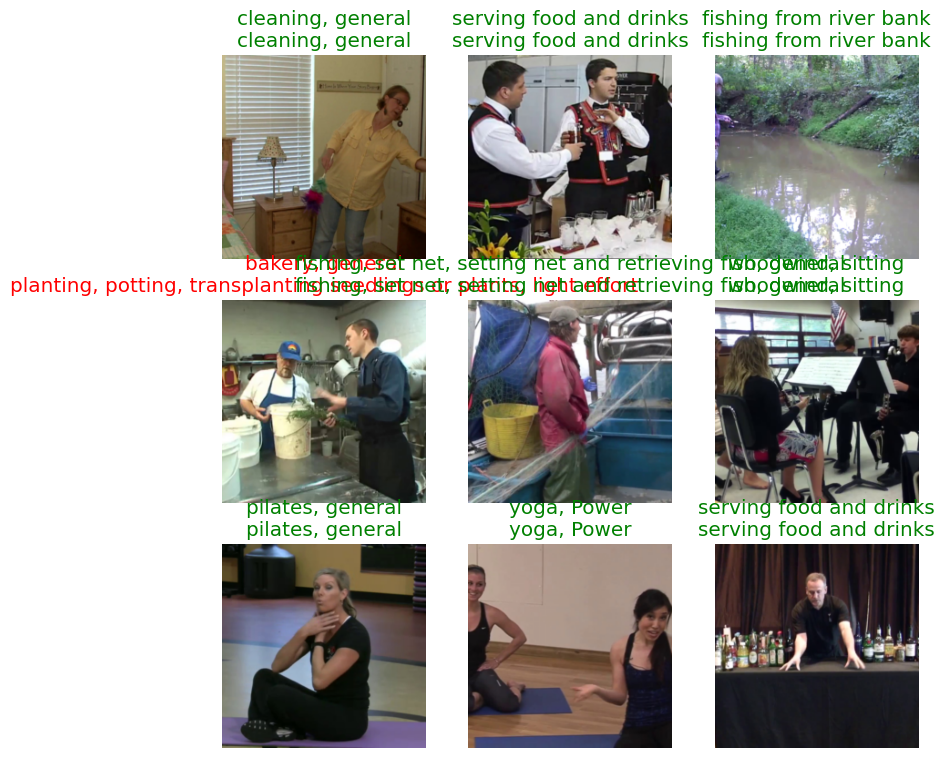

In [154]:
learner_resnet18.show_results()

El resultado visual también es similar ya que ambos modelos han obtneido un porcentaje de acierto parecido aunque el de la VGG ha sido un poco superior.

### **GoogleNet**

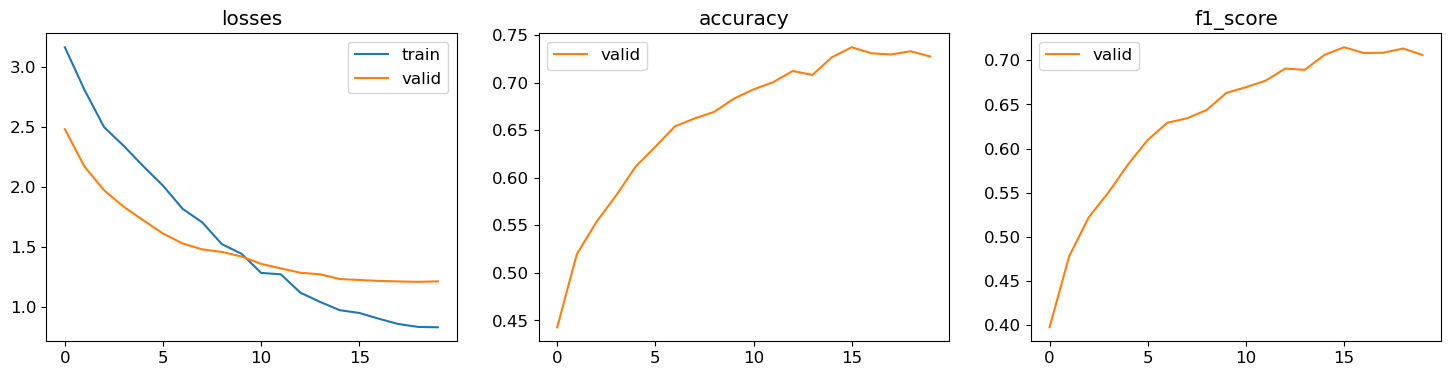

In [160]:
learner_googlenet.recorder.plot_metrics()

La gráfica de pérdidas de la GoogleNet es un poco mejor que la de los dos modelos anteriores ya que no hay tanta diferencia entre el error en validación y entrenamiento lo que sugiere un menor sobreajuste de los datos.

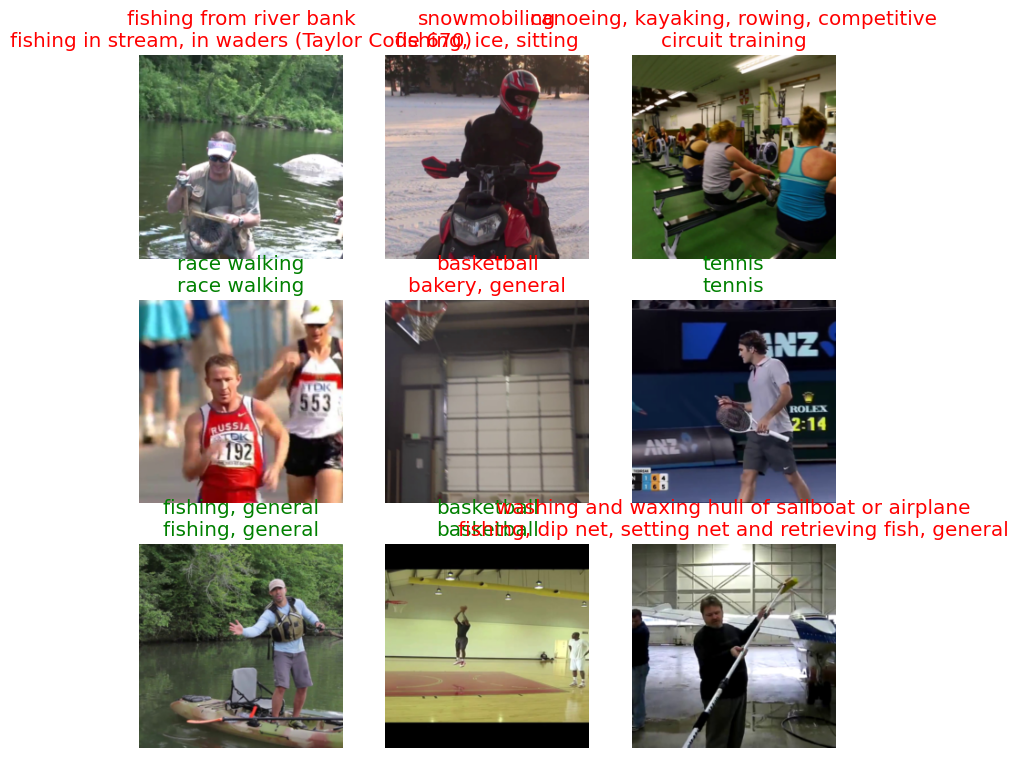

In [161]:
learner_googlenet.show_results()

Por otro lado el rendimiento de este modelo es peor que el de los dos anteriores y esto queda reflejado claramente a la hora de visualizar las predicciones sobre algunos ejemplos del conjunto de validación.

### **Comparación**

Creamos una tabla con los resultados de los modelos entrenados

In [164]:
VALID_LOSS_INDEX = 0
ACCURACY_INDEX = 1
F1SCORE_INDEX = 2

resultados_vgg = learner_vgg.validate()
resultados_resnet18 = learner_resnet18.validate()
resultados_googlenet = learner_googlenet.validate()


resumen_datos = {
    "Models": ["VGG16", "ResNet18", "GoogleNet"],
    "Valid Loss": [resultados_vgg[VALID_LOSS_INDEX], resultados_resnet18[VALID_LOSS_INDEX], resultados_googlenet[VALID_LOSS_INDEX]],
    "Accuracy": [resultados_vgg[ACCURACY_INDEX], resultados_resnet18[ACCURACY_INDEX], resultados_googlenet[ACCURACY_INDEX]],
    "F1 Score": [resultados_vgg[F1SCORE_INDEX], resultados_resnet18[F1SCORE_INDEX], resultados_googlenet[F1SCORE_INDEX]]
}

Better model found at epoch 0 with valid_loss value: 0.792792797088623.


Better model found at epoch 0 with valid_loss value: 0.7706167697906494.


Better model found at epoch 0 with valid_loss value: 0.7331947088241577.


In [165]:
df = pd.DataFrame(resumen_datos)
df

Models  Valid Loss  Accuracy  F1 Score
0      VGG16    0.976770  0.792793  0.782865
1   ResNet18    1.078472  0.770617  0.754634
2  GoogleNet    1.211387  0.733195  0.713459

De entre los modelos entrenados el que ha obtenido mejores resultados es el modelo que utiliza la VGG16, mejorando a los otros dos tanto en error de validación como en precisión y puntuación F1.

### **Modelo final**

Una vez tenemos el modelo final para nuestro problema lo evaluamos utilizando el conjunto de test que representa el 20% del total de nuestros datos originales.

In [171]:
# Creamos el dataloader de test a partir de los parametros de entrenamiento
test_dls = learner_vgg.dls.test_dl(df_test, with_labels=True)

# Calculamos las predicciones
preds, targs, _ = learner_vgg.get_preds(dl=test_dls, with_decoded=True)

# Calculamos el porcentaje de acierto
test_acc = accuracy(preds, targs)

print(f'Porcentaje de acierto en el conjunto de test: {round(float(test_acc) * 100, 2)} %')

Porcentaje de acierto en el conjunto de test: 78.54 %


El porcentaje de acierto en test es de `78,54%` mientras que en validación obtuvimos `79,28%` comprobando así que nuestro modelo final generaliza clasificando con la misma precisión datos que no ha visto nunca. La métrica de la puntuación F1 también es similar tanto en validación como en test reforzando la comprobación de que el modelo generaliza correctamente.

## **4.2 Clasificación de categorías**

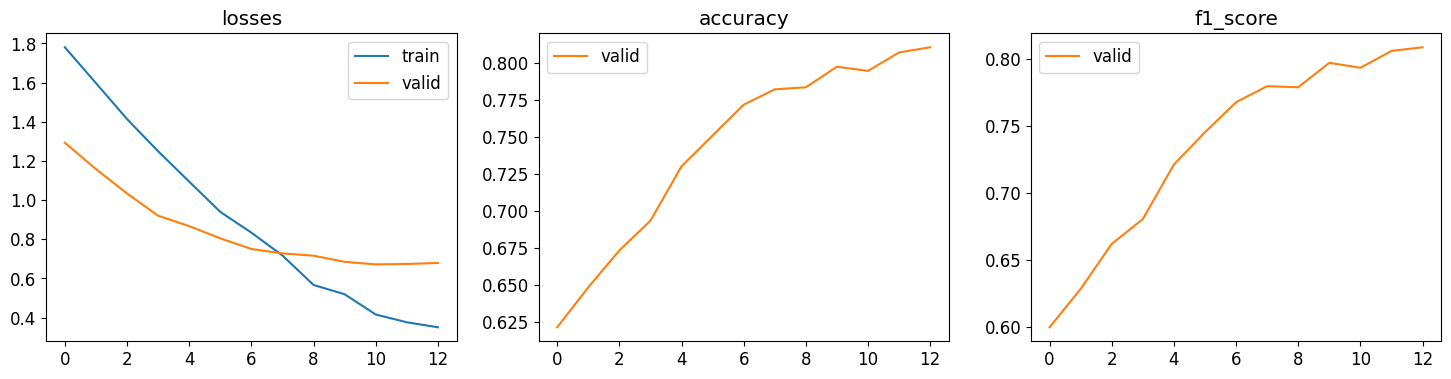

In [ ]:
learner_vgg16.recorder.plot_metrics()

La gráfica de pérdidas es algo mejor que la de la red que clasifica actividades ya que la que clasifica categorías muestra un comportamiento menos sobreajustado al haber menor diferencia entre el error en entrenamiento y validación.

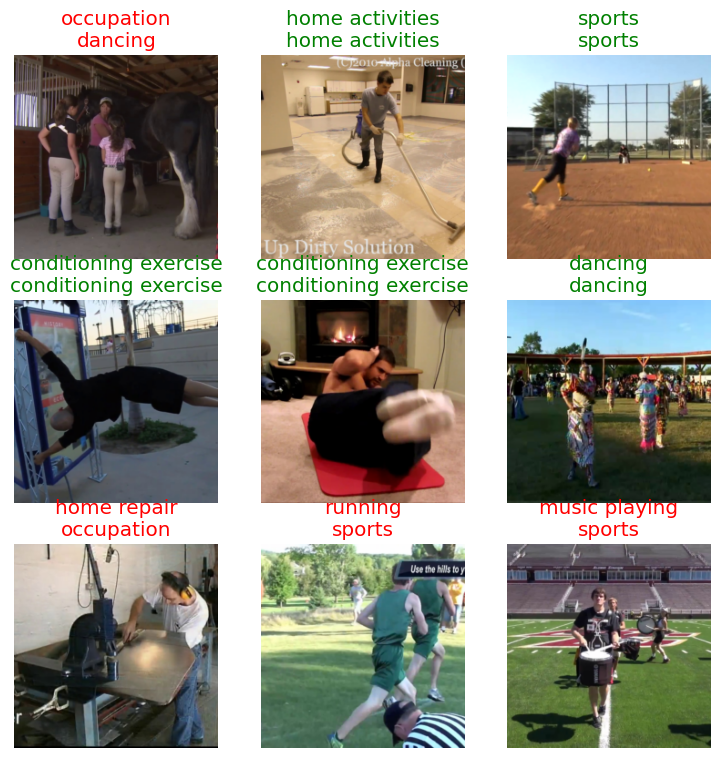

In [ ]:
learner_vgg16.show_results()

Visualizando algunas predicciones vemos que en general clasifica bien. Si nos fijamos observaremos que hay algunos errores que incluso un humano podría cometer como la clasificación de la imágen `running / sports` donde se ven dos chicos corriendo. Al ser las categorías tan generales es plausible que algunas imágenes pudieran adecuarse a más de una categoría.

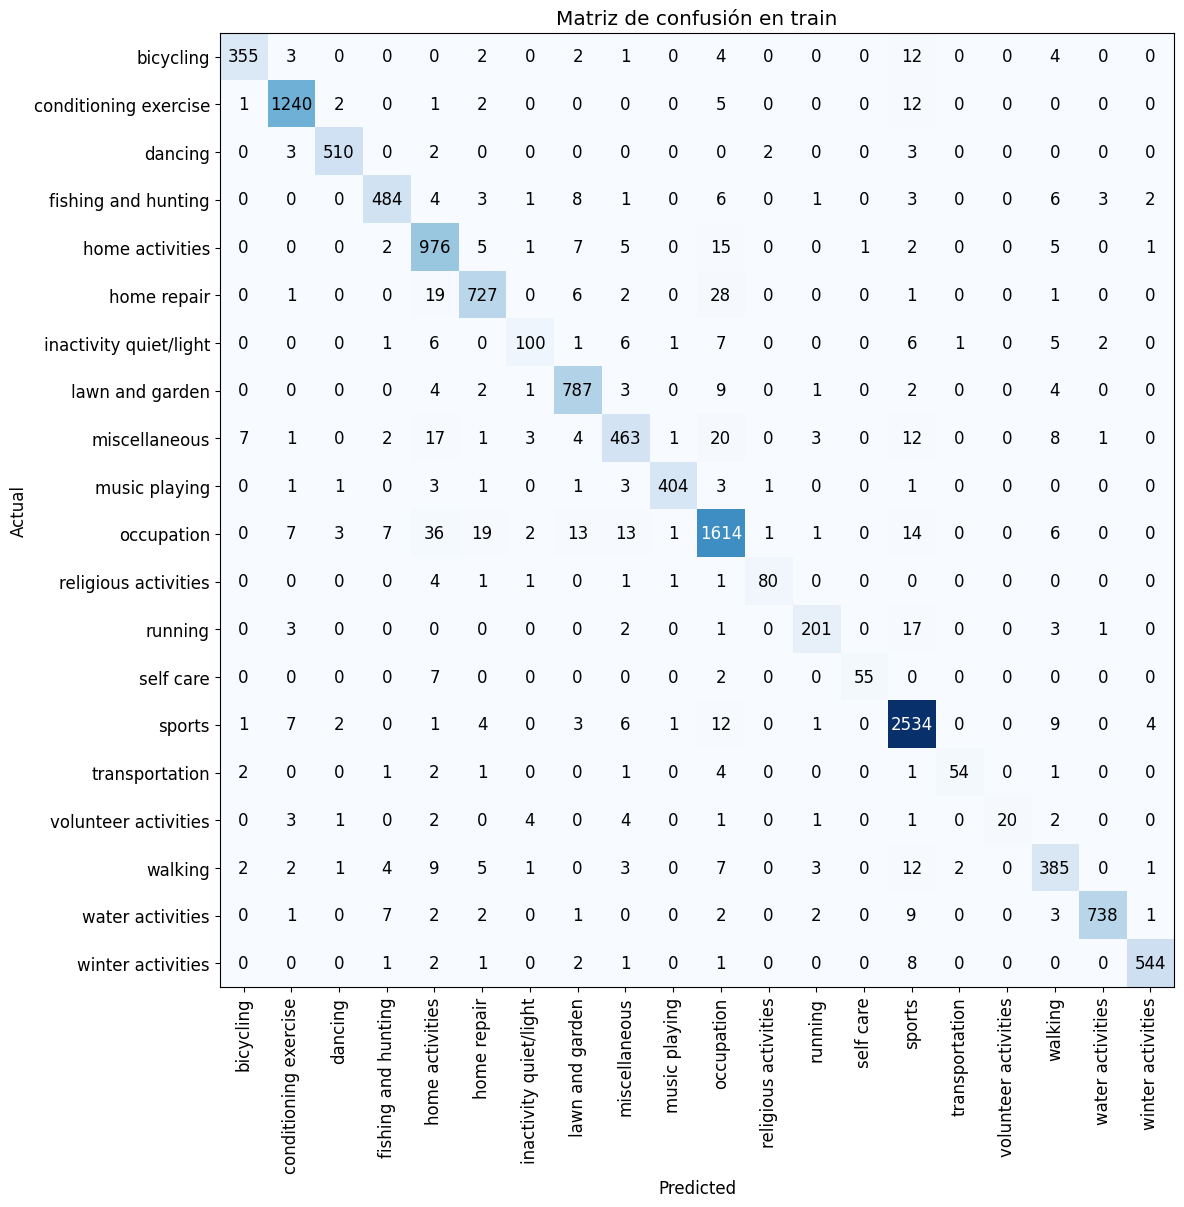

In [ ]:
interp = ClassificationInterpretation.from_learner(learner_vgg16, dl=dls.train)
interp.plot_confusion_matrix(figsize=(12, 12), title='Matriz de confusión en train')

Si nos fijamos en la matriz de confusión de entrenamiento podemos comprobar que, en general, no hay demasiadas clasificaciones erróneas menos en la fila de la categoría `occupation` que si que tiene ligeramente un mayor número de predicciones erróneas respecto a las clases `home repair`, `home activities`. Este comportamiento se debe a que estas categorías contienen imágenes de actividades muy similares.

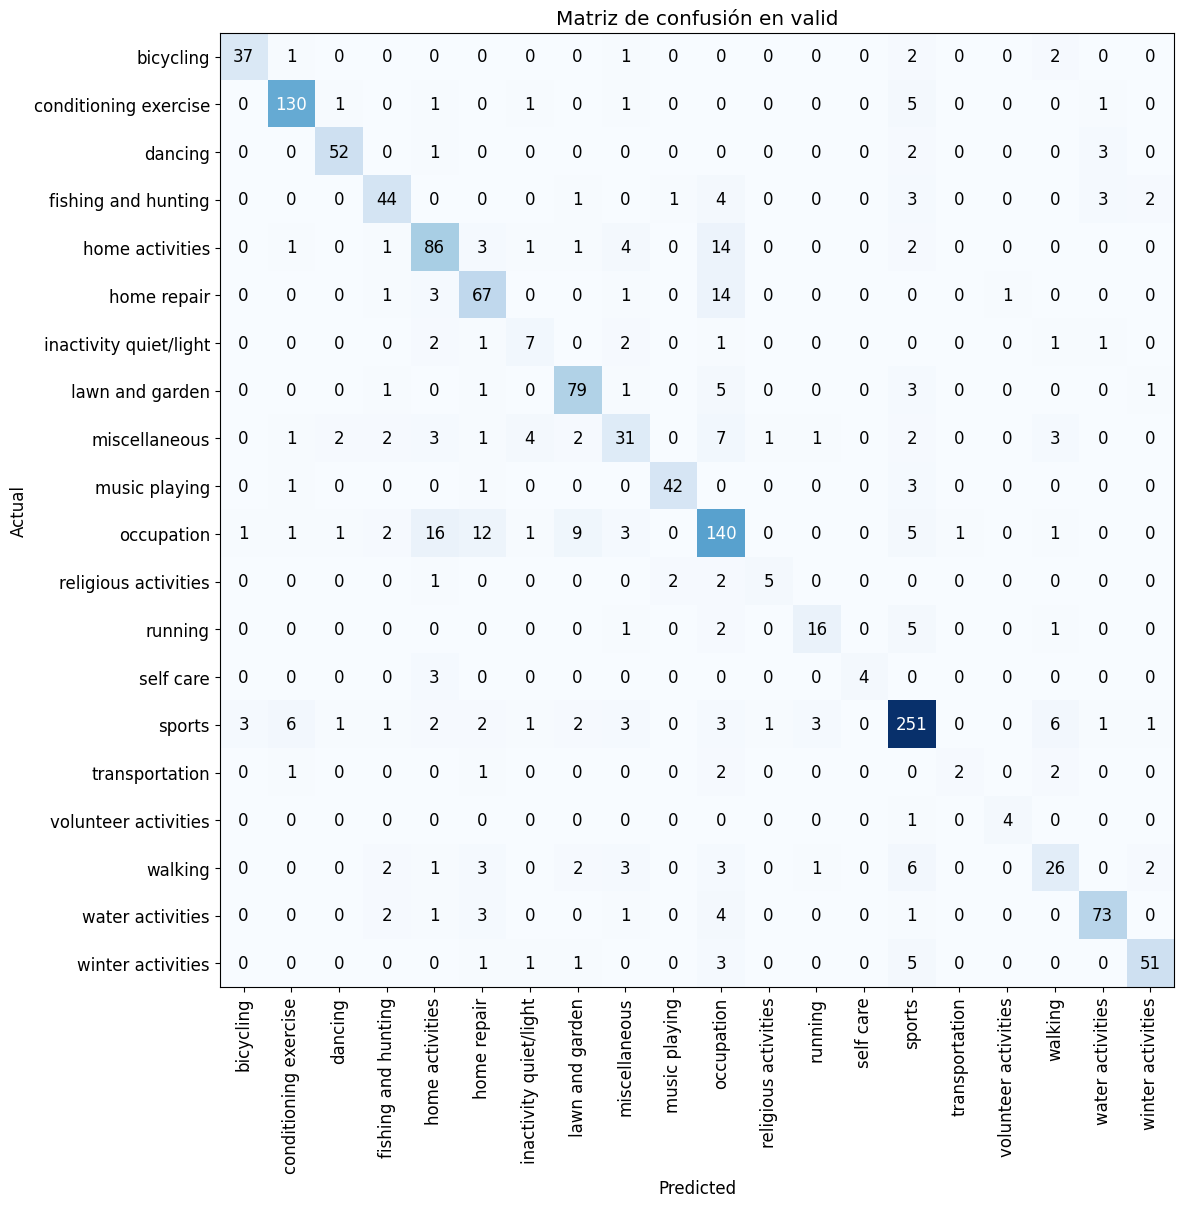

In [ ]:
interp_val = ClassificationInterpretation.from_learner(learner_vgg16, dl=dls.valid)
interp_val.plot_confusion_matrix(figsize=(12, 12), title='Matriz de confusión en valid')

En validación la matriz de confusión es muy similar, mostrando el mismo comportamiento en las categorías que hemos mencionado previamente.

In [ ]:
# Creamos el dataloader de test a partir de los parametros de entrenamiento
test_dls = learner_vgg16.dls.test_dl(df_test, with_labels=True)

# Calculamos las predicciones
preds, targs, _ = learner_vgg16.get_preds(dl=test_dls, with_decoded=True)

# Calculamos el porcentaje de acierto
test_acc = accuracy(preds, targs)

print(f'Porcentaje de acierto en el conjunto de test: {round(float(test_acc) * 100, 2)} %')

Porcentaje de acierto en el conjunto de test: 79.26 %


En el conjunto de entrenamiento obtuvimos un acierto del `79,49 %` mientras que en test hemos obtenido un acierto del `79,26%` verificando así que el modelo generaliza correctamente con datos que nunca ha visto durante la fase de entrenamiento.

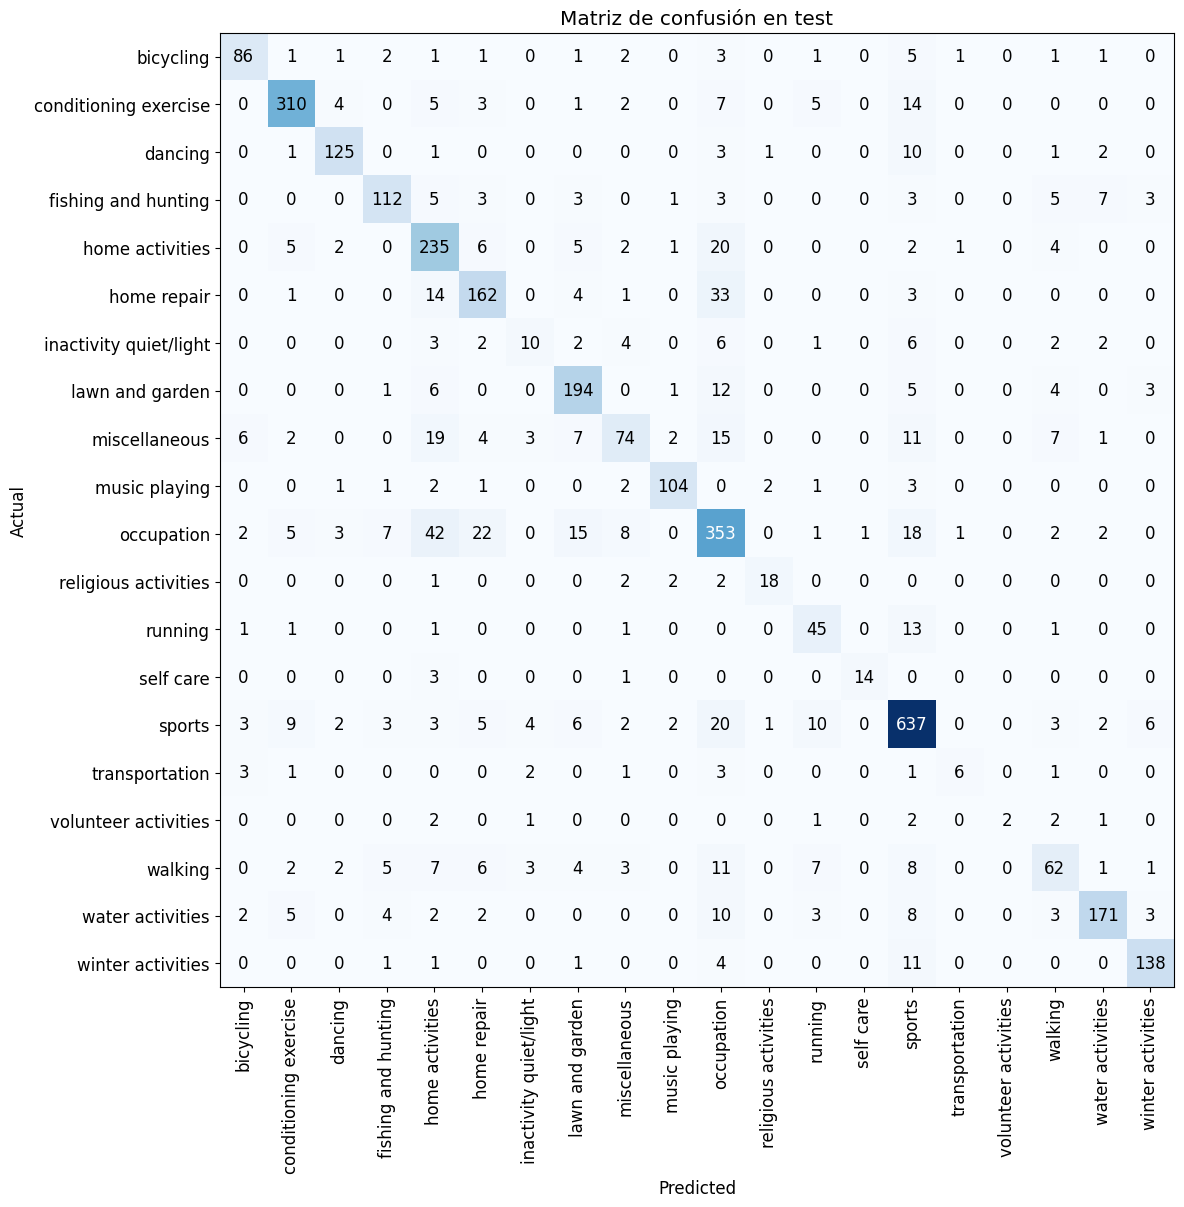

In [ ]:
interp_test = ClassificationInterpretation.from_learner(learner_vgg16, dl=test_dls)
interp_test.plot_confusion_matrix(figsize=(12, 12), title='Matriz de confusión en test')

En la matriz de confusión de test el comportamiento es similar que en la de entrenamiento y validación, especialmente con el problema de las categorías `occupation`, `home activities` y `home repair`. En este caso el número de confusiones respecto a estas categorías es más elevado que en los conjuntos de entrenamiento y test. Por lo demás podemos ver que, en general, no hay mucha confusión entre las distintas categorías.